## Metoda "korak po korak" za analizu dinamičke stabilnosti

M. i K. Ožegović, ELEKTRIČNE MREŽE III, Sveučilište u Splitu, FESB, Split, 1982.

![Primjer 1.10](slike/primjer_1_10.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Figure aesthetics.
import seaborn as sns
sns.set_theme(context='paper', style='white', font_scale=1.1)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})


![Metoda korak po korak](slike/korakpokorak.png)

In [ ]:
def korak_po_korak(H, Po, Pkv, Piv, Pnp, 
                   t_isk, APU_postoji, APU_uspjesan, tAPU, 
                   t_isk_end=0.1, tmax=1.0, dt=0.01, EPS=1e-3):
    """
    Metoda "korak po korak" za proracun dinamicke stabilnosti.

    Numericki proracun dinamicke stabilnosti jednostavnog EES-a
    pomocu tzv. metode korak po korak (varijanta Eulerove metode).
    Razmatra se nastup bilo koje vrste kratkog spoja (K3, K2, K1,
    K2Z) na jednom od dva paralelna voda kojim je elektrana (gene-
    rator i blok transformator) prikljucena na mrezu. Moguce je
    pritom dodatno uzeti u obzir djelovanje APU-a (tropolni) koji
    moze biti uspjesan ili neuspjesan.

    Arguments
    ---------
    H: float
        Konstanta inercije rotirajucih masa (MWs/MVA).
        Turbogeneratori: 5 - 8
        Hidrogeneratori: 2.5 - 4
        Sinhr. kompenz.: 1.25 - 2
    Po: float
        Mehanicka snaga u jed. vr.
    Pkv: float 
        Tjemena vrijednost snage prijenosa za vrijeme trajanja 
        kratkog spoja u jed. vr. 
    Piv: float
        Tjemena vrijednost snage prijenosa jednog voda u pogonu u jed. vr.
    Pnp: float
        Tjemena vrijednost snage prijenosa normalnog pogona (kada su oba 
        voda u pogonu) u jed. vr.
    t_isk: float
        Vrijeme odgode iskljucenja kvara (s).
    APU_postoji: bool
        Indikator postojanja (True) ili nepostojanje (False) 
        automatskog ponovnog uklopa na vodu. Rijec je o tropolnom APU
        kod kojeg se jedan vod (na kojem je bio kvar) stavlja izvan pogona.
    APU_uspjesan: bool
        Indikator uspjesnog (True) ili neuspjesnog (False) djelovanja
        APU-a, tj. indikator nestanka kvara nakon isteka beznaponske pauze. 
        Ako je APU bio neuspjesan, dolazi do ponovnog ukljucenja voda na 
        kvar i potom konacnog iskljucenja.
    tAPU: float
        Vrijeme trajanja beznaponske pauze APU-a (s).
    t_isk_end: float, default=0.1
        Vrijeme odgode konacnog iskljucenja kvara, nakon neuspjesnog
        APU-a (s). Ovo vrijeme moze biti i krace od inicijalnog
        vremena odgode iskljucenja kvara (`t_isk`).
    tmax: float, default=1.0
        Ukupno vrijeme promatranja dinamicke stabilnosti (s).
    dt: float, default=0.05
        Vremenski korak proracuna (s). Mora biti visekratnik
        vremena iskljucenja kvara (i vremena trajanja APU-a).
    EPS: float, default=1e-3
        Tolerancija za odredjivanje vremenskog trenutka iskljucenja
        kvara i vremena trajanja APU-a.
    
    Returns
    -------
    t: np.array
        Vrijeme (s).
    d: np.array
        Kut opterecenja (stupnjevi).
    
    Napomena
    --------
    Jedinicne vrijednosti snaga Po, Pkv, Piv, Pnp zadaju se u odnosu na
    nazivnu snagu generatora (Sn = 1).

    Literatura
    ----------
    M. i K. Ožegović, ELEKTRIČNE MREŽE III, Sveučilište u Splitu, 
    FESB, Split, 1982.
    """
    # Provjera zadanih vrijednosti ulaznih parametara.
    if t_isk <= dt:
        raise ValueError('Vrijeme iskljucenja kvara je prekratko.')
    if APU_postoji and tAPU <= dt:
        raise ValueError('Beznaponska pauza APU je prekratka.')
    if APU_postoji and tmax < t_isk+tAPU:
        raise ValueError('Vrijeme promatranja pojave je prekratko.')
    if APU_postoji is False and tmax < t_isk:
        raise ValueError('Vrijeme promatranja pojave je prekratko.')
    if dt < EPS:
        raise ValueError('EPS ne odgovara vremenskom koraku dt.')
    if int(divmod(t_isk, dt)[1]) != 0:
        print('UPOZORENJE: Vrijeme iskljucenja kvara nije visekratnik dt.')
    if APU_postoji and int(divmod(tAPU, dt)[1]) != 0:
        print('UPOZORENJE: Beznaponska pauza nije visekratnik dt.')

    # Konstante proracuna.
    Sn = 1.0  # p.u.
    k = 9000./(H*Sn)
    rad = np.pi/180.

    # Inicijalni kut operecenja.
    do = np.arcsin(Po/Pnp) * 180./np.pi

    # Alociranje memorije.
    N = int(tmax/dt) + 1
    t = np.arange(N)*dt    # vrijeme
    dd = np.empty_like(t)  # delta delta
    d = np.empty_like(t)   # delta
    
    # Kvar nastupa u pocetnom trenutku (t = 0 s).
    # Pocetni uvjeti:
    Pe = Pkv * np.sin(do*rad)
    alpha = k * (Po-Pe)
    omega = alpha*dt/2.
    dd[0] = omega*dt/2. + alpha*(dt/2.)**2
    d[0] = do + dd[0]

    if APU_postoji:
        # Postoji APU na vodu.
        for i in range(1, N):
            # Za vrijeme trajanja kratkog spoja.
            if t[i] < t_isk:
                Pe = Pkv * np.sin(d[i-1]*rad)
                alpha = k * (Po-Pe)
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - t_isk) <= EPS:
                # Trenutak iskljucenja kratkog spoja.
                Pe1 = Pkv * np.sin(d[i-1]*rad)
                Pe2 = Piv * np.sin(d[i-1]*rad)
                dp1 = Po - Pe1
                dp2 = Po - Pe2
                dp = (dp1+dp2)/2.
                alpha = k*dp
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            elif t_isk < t[i] < t_isk+tAPU:
                # Nakon iskljucenja voda u kvaru (tece
                # beznaponska pauza).
                Pe = Piv * np.sin(d[i-1]*rad)
                alpha = k * (Po-Pe)
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - (t_isk+tAPU)) <= EPS:
                # Trenutak isteka beznaponske pauze APU-a.
                if APU_uspjesan:
                    # APU je uspjesan.
                    Pe1 = Piv * np.sin(d[i-1]*rad)
                    Pe2 = Pnp * np.sin(d[i-1]*rad)
                else:
                    # APU je neuspjesan.
                    Pe1 = Piv * np.sin(d[i-1]*rad)
                    Pe2 = Pkv * np.sin(d[i-1]*rad)
                dp1 = Po - Pe1
                dp2 = Po - Pe2
                dp = (dp1+dp2)/2.
                alpha = k*dp
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            elif t[i] > t_isk+tAPU:
                # Nakon vremena isteka beznaponske pauze.
                if APU_uspjesan:
                    # APU je uspjesan.
                    # Sustav se vraca u normalno pogonsko stanje.
                    Pe = Pnp * np.sin(d[i-1]*rad)
                    alpha = k * (Po-Pe)
                    dd[i] = dd[i-1] + alpha*dt**2
                    d[i] = d[i-1] + dd[i]
                else:
                    # APU je neuspjesan.
                    # Ponovno ukljucenje na kvar do konacnog iskljucenja.
                    if t_isk+tAPU < t[i] < t_isk+tAPU+t_isk_end:
                        # Vrijeme odgode iskljucenja kvara nakon
                        # neuspjesnog APU-a moze biti krace od
                        # inicijalnog vremena odgode iskljucenja kvara.
                        Pe = Pkv * np.sin(d[i-1]*rad)
                        alpha = k * (Po-Pe)
                        dd[i] = dd[i-1] + alpha*dt**2
                        d[i] = d[i-1] + dd[i]
                    elif abs(t[i] - (t_isk+tAPU+t_isk_end)) <= EPS:
                        # Trenutak konacnog iskljucenja kvara.
                        Pe1 = Pkv * np.sin(d[i-1]*rad)
                        Pe2 = Piv * np.sin(d[i-1]*rad)
                        dp1 = Po - Pe1
                        dp2 = Po - Pe2
                        dp = (dp1+dp2)/2.
                        alpha = k*dp
                        dd[i] = dd[i-1] + alpha*dt**2
                        d[i] = d[i-1] + dd[i]
                    else:
                        # Nakon konacnog iskljucenje kvara slijedom 
                        # neuspjesnog APU-a, sustav nastavlja pogon
                        # samo s jednim vodom.
                        Pe = Piv * np.sin(d[i-1]*rad)
                        alpha = k * (Po-Pe)
                        dd[i] = dd[i-1] + alpha*dt**2
                        d[i] = d[i-1] + dd[i]
    else:
        # APU ne postoji.
        for i in range(1, N):
            if t[i] < t_isk:
                # Za vrijeme trajanja kratkog spoja.
                Pe = Pkv * np.sin(d[i-1]*rad)
                alpha = k * (Po-Pe)
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            elif abs(t[i] - t_isk) <= EPS:
                # Trenutak iskljucenja kratkog spoja.
                Pe1 = Pkv * np.sin(d[i-1]*rad)
                Pe2 = Piv * np.sin(d[i-1]*rad)
                dp1 = Po - Pe1
                dp2 = Po - Pe2
                dp = (dp1+dp2)/2.
                alpha = k*dp
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
            else:
                # Nakon iskljucenja voda u kvaru.
                # Sustav nastavlja pogon samo s jednim vodom.
                Pe = Piv * np.sin(d[i-1]*rad)
                alpha = k * (Po-Pe)
                dd[i] = dd[i-1] + alpha*dt**2
                d[i] = d[i-1] + dd[i]
    
    return (t, d)

### Elektricne Mreze III, Primjer 1.10

In [4]:
# Ozegovic, Elektricne mreze III, Primjer 1.10, str. 101.
# Ulazni podaci:
H = 3.  # Konstanta inercije.

# Tjemene vrijednosti snaga prijenosa:
Po = 0.8     # Mehanicka snaga (j.v.)
Pk3 = 0.302  # Snaga tropolnog kratkog spoja (j.v.)
Piv = 1.129  # Snaga nakon iskljucenja kvara (j.v.)
Pnp = 1.368  # Snaga normalnog pogona (j.v.)

t_isk = 0.15  # Vrijeme iskljucenja kvara.
APU_postoji = True  # APU postoji na vodu.
APU_uspjesan = True # APU je uspjesan.
tAPU = 0.4   # Vrijeme trajanja beznaponske pauze APU (s).
t_isk_end = 0.15  # Vrijeme iskljucenja nakon neuspjesnog APU (s).
tmax = 0.7  # Vrijeme promatranja dinamicke stabilnosti (s).
dt = 0.05    # Vremenski korak proracuna (s).

#### Dalekovod ima APU koji je uspješan.

![APU uspjesno](slike/APU_uspjesno.png)

In [5]:
# Osnovna varijanta (APU uspjesno).
t, d = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                      t_isk, APU_postoji, APU_uspjesan, 
                      tAPU, t_isk_end, tmax, dt)

In [6]:
# Usporediti s rezultatima u Tablici 1.1 (str. 102).
print(d.round(2))

[38.13 45.07 56.4  69.27 80.21 88.82 94.95 98.66 99.99 98.98 95.6  88.91
 77.96 62.98]


#### Dalekovod ima APU koji je neuspješan.

![APU neuspjesno](slike/APU_neuspjesno.png)

In [7]:
APU_uspjesan = False  # Varijanta: APU je neuspjesno.
t, d_neuspjeh = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                               t_isk, APU_postoji, APU_uspjesan, 
                               tAPU, t_isk_end, tmax, dt)

#### Dalekovod nema APU.

![APU ne postoji](slike/APU_ne_postoji.png)

In [8]:
APU_postoji = False  # Varijanta: Dalekovod nema APU.
t, d_noAPU = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                            t_isk, APU_postoji, APU_uspjesan, 
                            tAPU, t_isk_end, tmax, dt)

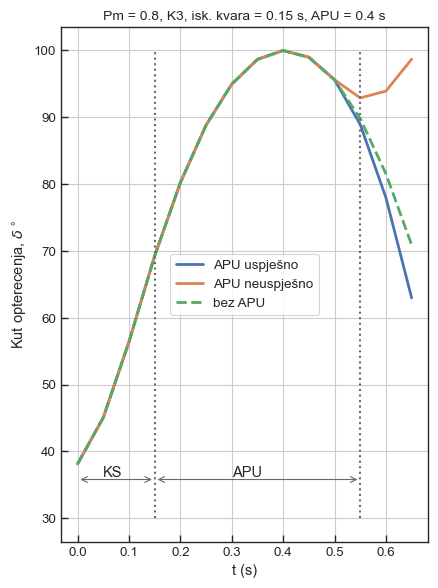

In [9]:
# Ozegovic, Elektricne mreze III, Primjer 1.10, Slika 57, str. 107.
fig, ax = plt.subplots(figsize=(4.5,6))
ax.set_title(f'Pm = {Po}, K3, isk. kvara = {t_isk} s, APU = {tAPU} s', 
             fontdict={'size':10})
# Prikazi krivulje promjene kuta opterecenja.
ax.plot(t, d, lw=2, label='APU uspješno')
ax.plot(t, d_neuspjeh, lw=2, label='APU neuspješno')
ax.plot(t, d_noAPU, ls='--', lw=2, label='bez APU')
# Oznaci vremenske trenutke od interesa.
low, high = 30, 100
ax.vlines(t_isk, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
ax.vlines(t_isk+tAPU, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
do = np.arcsin(Po/Pnp)*180/np.pi
ax.annotate('KS', xy=(t_isk-0.1, do), va='bottom')
ax.annotate('', xy=(0, do), xytext=(t_isk, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
ax.annotate('APU', xy=(tAPU-0.1, do), va='bottom')
ax.annotate('', xy=(t_isk, do), xytext=(t_isk+tAPU, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
# Koordinatne osi i legenda.
ax.legend(loc='center')
ax.set_xlabel('t (s)')
ax.set_ylabel('Kut opterecenja, ' + r'$\delta \, ^{\circ}$')
ax.grid(visible=True, which='major', axis='both')
fig.tight_layout()
plt.show()

In [10]:
# Varijanta: Veci prijenos snage u trenutku nastupa kvara.
Po = 0.9  # jed. vr.
APU_postoji = True
APU_uspjesan = True
t, d = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                      t_isk, APU_postoji, APU_uspjesan, 
                      tAPU, t_isk_end, tmax, dt)

In [11]:
# Usporediti s rezultatima u Tablici 1.2 (str. 103).
print(d.round(2))

[ 43.77  51.58  64.37  79.07  92.21 103.63 113.58 122.51 131.06 139.97
 150.18 162.49 178.46 200.91]


In [12]:
# APU neuspjesno (Pm = 0.9).
APU_uspjesan = False
t, dn = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                       t_isk, APU_postoji, APU_uspjesan, 
                       tAPU, t_isk_end, tmax, dt)

In [13]:
APU_postoji = False  # APU ne postoji.
t, dno = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                        t_isk, APU_postoji, APU_uspjesan, 
                        tAPU, t_isk_end, tmax, dt)

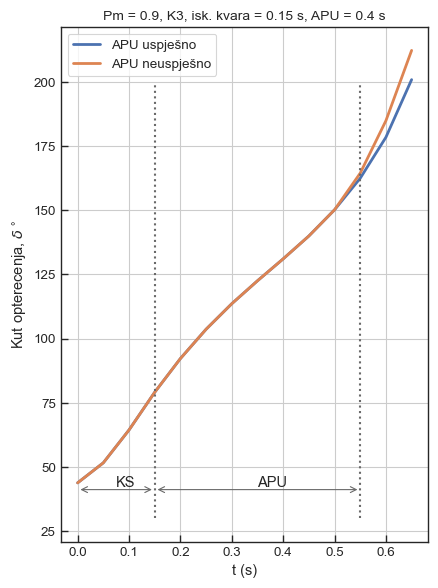

In [14]:
# Ozegovic, Elektricne mreze III, Primjer 1.10, Slika 57, str. 107.
fig, ax = plt.subplots(figsize=(4.5,6))
ax.set_title(f'Pm = {Po}, K3, isk. kvara = {t_isk} s, APU = {tAPU} s', 
             fontdict={'size':10})
# Prikazi krivulje promjene kuta opterecenja.
ax.plot(t, d, lw=2, label='APU uspješno')
ax.plot(t, dn, lw=2, label='APU neuspješno')
# Oznaci vremenske trenutke od interesa.
low, high = 30, 200
ax.vlines(t_isk, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
ax.vlines(t_isk+tAPU, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
do = np.arcsin(Po/Pnp)*180/np.pi
ax.annotate('KS', xy=(t_isk/2, do), va='bottom')
ax.annotate('', xy=(0, do), xytext=(t_isk, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
ax.annotate('APU', xy=(t_isk+tAPU/2, do), va='bottom')
ax.annotate('', xy=(t_isk, do), xytext=(t_isk+tAPU, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
# Koordinatne osi i legenda.
ax.legend(loc='upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel('Kut opterecenja, ' + r'$\delta \, ^{\circ}$')
ax.grid(visible=True, which='major', axis='both')
fig.tight_layout()
plt.show()

In [15]:
# Varijanta: Dvopolni kratki spoj.
Pk2 = 0.822
t, d2 = korak_po_korak(H, Po, Pk2, Piv, Pnp, 
                       t_isk, APU_postoji, APU_uspjesan, 
                       tAPU, t_isk_end, tmax, dt)

In [16]:
# Varijanta: Jednopolni kratki spoj.
Pk1 = 1.067
t, d1 = korak_po_korak(H, Po, Pk1, Piv, Pnp, 
                       t_isk, APU_postoji, APU_uspjesan, 
                       tAPU, t_isk_end, tmax, dt)

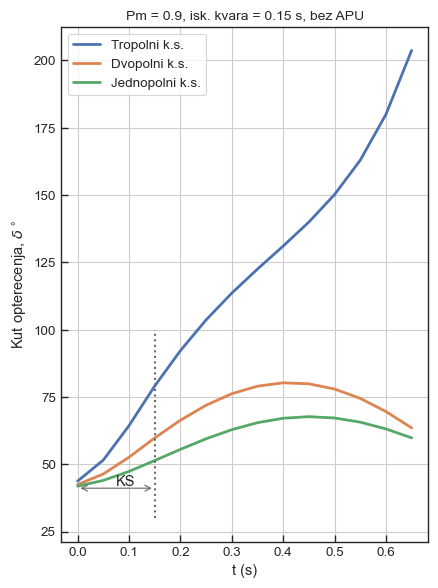

In [17]:
fig, ax = plt.subplots(figsize=(4.5,6))
ax.set_title(f'Pm = {Po}, isk. kvara = {t_isk} s, bez APU', fontdict={'size':10})
# Prikazi krivulje promjene kuta opterecenja.
ax.plot(t, dno, lw=2, label='Tropolni k.s.')
ax.plot(t, d2, lw=2, label='Dvopolni k.s.')
ax.plot(t, d1, lw=2, label='Jednopolni k.s.')
# Oznaci vremenske trenutke od interesa.
low, high = 30, 100
ax.vlines(t_isk, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
do = np.arcsin(Po/Pnp)*180/np.pi
ax.annotate('KS', xy=(t_isk/2, do), va='bottom')
ax.annotate('', xy=(0, do), xytext=(t_isk, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
# Koordinatne osi i legenda.
ax.legend(loc='upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel('Kut opterecenja, ' + r'$\delta \, ^{\circ}$')
ax.grid(visible=True, which='major', axis='both')
fig.tight_layout()
plt.show()

In [18]:
# Varijanta: Duze vrijeme trajanja dvopolnog kratkog spoja.
t_isk_new = 0.4
t, d2t = korak_po_korak(H, Po, Pk2, Piv, Pnp, 
                        t_isk_new, APU_postoji, APU_uspjesan, 
                        tAPU, t_isk_end, tmax, dt)

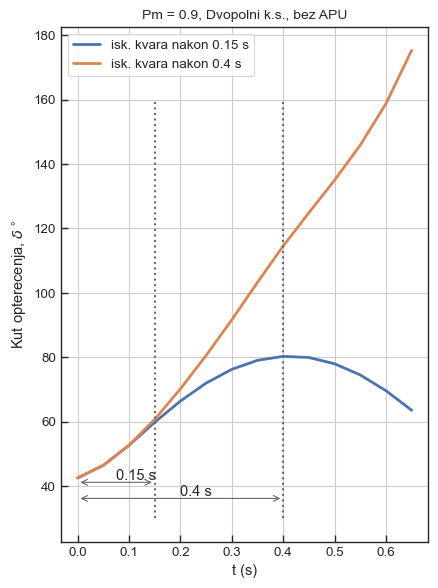

In [19]:
fig, ax = plt.subplots(figsize=(4.5,6))
ax.set_title(f'Pm = {Po}, Dvopolni k.s., bez APU', fontdict={'size':10})
# Prikazi krivulje promjene kuta opterecenja.
ax.plot(t, d2, lw=2, label='isk. kvara nakon 0.15 s')
ax.plot(t, d2t, lw=2, label='isk. kvara nakon 0.4 s')
# Oznaci vremenske trenutke od interesa.
low, high = 30, 160
ax.vlines(t_isk, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
ax.vlines(t_isk_new, low, high, lw=1.5, colors='dimgrey', linestyles='dotted')
do = np.arcsin(Po/Pnp)*180/np.pi
ax.annotate('0.15 s', xy=(t_isk/2, do), va='bottom')
ax.annotate('', xy=(0, do), xytext=(t_isk, do),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
ax.annotate('0.4 s', xy=(t_isk_new/2, do-5), va='bottom')
ax.annotate('', xy=(0, do-5), xytext=(t_isk_new, do-5),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
# Koordinatne osi i legenda.
ax.legend(loc='upper left')
ax.set_xlabel('t (s)')
ax.set_ylabel('Kut opterecenja, ' + r'$\delta \, ^{\circ}$')
ax.grid(visible=True, which='major', axis='both')
fig.tight_layout()
plt.show()

### Dodatak: Primjer iz knjige S. Despotović

In [20]:
# S. Despotović, OSNOVI ANALIZE ELEKTROENERGETSKIH SISTEMA,
# Zajednica Jugoslovenske Elektroprivrede, Beograd, 1962.
# Primjer primene metode korak po korak (str. 231).
H = 2.3
Po = 0.8
# Tropolni kratki spoj na dvostrukom vodu (bez APU).
# Tjemene vrijednosti snaga prijenosa (moj proracun):
Pk3 = 0.94
Piv = 2.06
Pnp = 2.575
# Napomena: U knjizi se primjenjuje mrezni analizator u
# kombinaciji s metodom korak po korak.

t_isk = 0.4
APU_postoji = False  # bez APU
tmax = 1.0
dt = 0.01

In [21]:
t, d = korak_po_korak(H, Po, Pk3, Piv, Pnp, 
                      t_isk, APU_postoji, APU_uspjesan, 
                      tAPU, t_isk_end, tmax, dt)

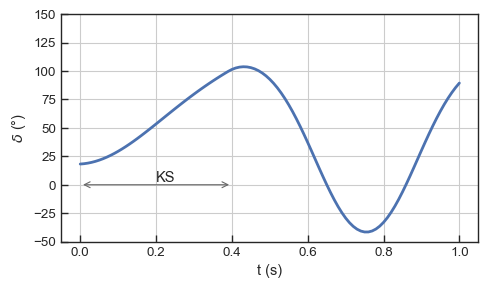

In [22]:
# Usporediti sa Slikom 5.4 na str. 233.
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(t, d, lw=2)
ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\delta$'+' (°)')
ax.set_ylim(-50, 150)
ax.annotate('KS', xy=(t_isk/2, 0), va='bottom')
ax.annotate('', xy=(0, 0), xytext=(t_isk, 0),
            arrowprops={'color':'dimgrey', 'arrowstyle':'<->'})
ax.grid()
fig.tight_layout()
plt.show()